In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils, probeReadWrite
from pyCascade.probeReadWrite import read_probes_file_switch
from filloutVentilationStats import *
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from cycler import cycler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import statsmodels.api as sm
import warnings
import ast
from scipy.optimize import minimize
import seaborn as sns

plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


'/Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd'

'/Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd'

# Setup

## Runs

In [38]:
multiRun_dir = f"{home_dir}/CHARLES/multiRuns/"
plotFolder = f"{multiRun_dir}"

## Read in results

In [39]:
def evalStringAsList(s):
    if isinstance(s, str) and s[0] == "[" and s[-1] == "]":
        return ast.literal_eval(s)
    else:
        return s

In [ ]:
flowStatsMI = pd.read_csv(f"{multiRun_dir}/flowStatsMI.csv", index_col = [0,1])
roomVentilationMI = pd.read_csv(f"{multiRun_dir}/roomVentilationMI.csv", index_col = [0,1])

flowStatsMI = combine_stats(flowStatsMI, ["WS", "delT", "SS", "C", "A"])
roomVentilationMI = combine_stats(roomVentilationMI,   ["WS", "delT", "SS", "C", "A"])

In [42]:
# 2*flowStatsMI2.loc[2495]["rms-sn_prod(abs(u))-Norm"]**2 - flowStatsMI.loc[2460]["rms-sn_prod(abs(u))-Norm"]**2 - flowStatsMI.loc[2530]["rms-sn_prod(abs(u))-Norm"]**2

Index([2530, 2550, 2531, 2551, 2532, 2552, 2540, 2560, 2541, 2561, 2542, 2562,
       3210, 3230, 3211, 3231, 3212, 3232, 3220, 3240, 3221, 3241, 3222, 3242],
      dtype='int64')

In [7]:
pcOverwrite = False

if pcOverwrite or os.path.exists(f"{multiRun_dir}/pointCloudStatsNoIntMI.csv") == False:
    # pointCloud pressure probes
    runIndex = flowStatsMI.index.get_level_values(0).unique()
    runIndex = np.sort(runIndex)
    runNumOffsetC2 = 57 - (46 + 53) / 2
    runNumOffsetC3 = 25 - (16 + 21) / 2
    pcStats = pd.DataFrame()

    def addB(name):
        if name.split("_")[-1][0] != "B":
            return f"{name}_B"
        return name

    for run in runIndex:
        runString = str(run)
        C = runString[0]
        if C == "2":
            runNumOffset = runNumOffsetC2
        elif C == "3":
            runNumOffset = runNumOffsetC3

        R = int((run % 1000)/10 + runNumOffset)
        V = runString[-1]
        if V == '0':
            oak_probes_dir =  f'{home_dir}/CHARLES/config{C}/R{R}/probes/probesOut_parquet/pointCloud'
            print(oak_probes_dir)
            probes = probePost.Probes(
                oak_probes_dir, 
                probe_type = "POINTCLOUD_PROBES", 
                file_type = "parquet", 
                directory_parquet = oak_probes_dir,
            )
            stats = probes.statistics(quants = [119000])
            stats = stats.map(lambda df: df["p_avg"].mean())

            stats.index = stats.index.map(addB)
            stats = stats.rename(columns={119000: 'pNoInt'})
        stats["run"] = run
        pcStats = pd.concat([pcStats, stats], axis = "rows")


        # probes_dir = f'{home_dir}/CHARLES/config{C}/R{R}/probes/probesOut_parquet'
        # EPprobes = probePost.Probes(probes_dir, directory_parquet = probes_dir, file_type = "parquet")

        # nameKey = read_probes_file_switch(f"{probes_dir}/../locations/nameKey_extraProbe.txt")
        # nameKey = nameKey.compute()
        # nameKey = pd.concat([nameKey, EPprobes.locations["extraProbe"]], axis = "columns")

        # break

    pcStatsMI = pcStats.reset_index()
    pcStatsMI = pcStatsMI.set_index(['run', 'index'])
    pcStatsMI.to_csv(f"{multiRun_dir}/pointCloudStatsNoIntMI.csv")
else:
    pcStatsMI = pd.read_csv(f"{multiRun_dir}/pointCloudStatsNoIntMI.csv", index_col=[0,1])

pcStatsMI

pNoInt
run  index                           
2530 xwindow_0-0_h_0--1_B    0.184227
     xwindow_0-0_h_0--1_Bx   0.035007
     xwindow_0-0_h_0--1_Bxz -0.037380
     xwindow_0-0_h_0--1_Bz  -0.393898
     xwindow_0-0_h_0--2_B   -0.018958
...                               ...
3242 zwindow_2-1_h_0-2_Bz   -2.854836
     zwindow_2-1_sl_B        0.309780
     zwindow_2-1_sl_Bx       3.695106
     zwindow_2-1_sl_Bxz     -0.782845
     zwindow_2-1_sl_Bz      -3.134572

[4608 rows x 1 columns]

In [8]:
flowStatsMI["pNoInt"] = np.nan
flowStatsMI.update(pcStatsMI)
flowStatsMI

mean-mass_flux  mean-mass_flux(D)  \
2530 xwindow_0-0_h_0--1_B        0.029436          -0.027820   
     zwindow_0-0_h_0--1_B       -0.028546          -0.025081   
     zwindow_2-0_h_0--1_B        0.124915          -0.018044   
     zwindow_2-1_h_0--1_B       -0.124819          -0.076469   
     xwindow_0-1_h_0--1_B        0.151703          -0.009008   
...                                   ...                ...   
3242 xwindow_0-1_sl_Bz           0.722177           0.001410   
     zwindow_0-1_sl_Bz          -0.158528          -0.029477   
     zwindow_1-1_sl_Bz           0.664727          -0.007770   
     skylight_1-0_sl_Bz         -0.895524          -0.109206   
     zwindow_1-0_sl_Bz           0.885028          -0.001691   

                           mean-mass_flux(S)  mean-mass_flux(T)  \
2530 xwindow_0-0_h_0--1_B          -0.078058           0.000000   
     zwindow_0-0_h_0--1_B          -0.089592           0.000000   
     zwindow_2-0_h_0--1_B          -0.031893           0.000000   
     zwindow_2-1_h_0--1_B          -0.122358           0.000000   
     xwindow_0-1_h_0--1_B          -0.020242           0.000000   
...                                      ...                ...   
3242 xwindow_0-1_sl_Bz              0.012205           0.011129   
     zwindow_0-1_sl_Bz             -0.170634          -0.170638   
     zwindow_1-1_sl_Bz             -0.015215          -0.016201   
     skylight_1-0_sl_Bz            -0.549370          -0.548790   
     zwindow_1-0_sl_Bz             -0.015443          -0.016941   

                           mean-mass_flux(p)  mean-sn_prod(abs(u))  \
2530 xwindow_0-0_h_0--1_B           0.042634              0.247933   
     zwindow_0-0_h_0--1_B           0.003220              0.219054   
     zwindow_2-0_h_0--1_B           0.042747              0.228317   
     zwindow_2-1_h_0--1_B          -0.000965              0.202972   
     xwindow_0-1_h_0--1_B           0.000447              0.205898   
...                                      ...                   ...   
3242 xwindow_0-1_sl_Bz             -1.609462              0.736617   
     zwindow_0-1_sl_Bz              0.890212              0.561531   
     zwindow_1-1_sl_Bz             -1.579698              0.618890   
     skylight_1-0_sl_Bz            -2.746309              0.796699   
     zwindow_1-0_sl_Bz              3.666496              0.801911   

                           mean-sn_prod(p)  mean-sn_prod(u)  \
2530 xwindow_0-0_h_0--1_B         0.235881         0.009125   
     zwindow_0-0_h_0--1_B         0.241472        -0.019567   
     zwindow_2-0_h_0--1_B         0.122070         0.095055   
     zwindow_2-1_h_0--1_B         0.067519        -0.100069   
     xwindow_0-1_h_0--1_B        -0.048770         0.086624   
...                                    ...              ...   
3242 xwindow_0-1_sl_Bz           -2.227255         0.575891   
     zwindow_0-1_sl_Bz           -2.557526        -0.155818   
     zwindow_1-1_sl_Bz           -2.280278         0.497617   
     skylight_1-0_sl_Bz           2.791117        -0.726236   
     zwindow_1-0_sl_Bz            3.428110         0.674265   

                           mean-sn_prod(u**2)  rms-mass_flux  ...  \
2530 xwindow_0-0_h_0--1_B            0.109987       0.279057  ...   
     zwindow_0-0_h_0--1_B            0.089726       0.278098  ...   
     zwindow_2-0_h_0--1_B            0.098813       0.248563  ...   
     zwindow_2-1_h_0--1_B            0.073155       0.245840  ...   
     xwindow_0-1_h_0--1_B            0.071628       0.161536  ...   
...                                       ...            ...  ...   
3242 xwindow_0-1_sl_Bz               0.847545       0.431940  ...   
     zwindow_0-1_sl_Bz               0.518647       0.700573  ...   
     zwindow_1-1_sl_Bz               0.550634       0.532818  ...   
     skylight_1-0_sl_Bz              0.824951       0.591366  ...   
     zwindow_1-0_sl_Bz               0.916229       0.581521  ...   

                          

In [45]:
g = 10
beta = 0.0034
rho = 1.225
hm = 6
window_dim = hm/2/4
A = window_dim ** 2

def getWindBuoyantP(rho, flowParams):
    p_w = flowParams["p_w"]
    z = flowParams["z"]
    delT = flowParams["delT"]
    delrho = -rho * beta * delT
    return (delrho * g * z) + p_w # delP is outdoor minus indoor, while p0/rho is indoor minus outdoor, driving positive flow into the room (oppiste textbook)

def flowFromP(rho, C_d, A, delp):
    delp=np.array(delp)
    S = np.zeros_like(delp)
    S[delp!=0] = abs(delp[delp!=0]) / delp[delp!=0]
    return S * C_d * A * np.sqrt(2 * abs(delp) / rho)

def CFromFlow(rho, q, A, delp):
    delp=np.array(delp)
    S = np.zeros_like(delp)
    S[delp!=0] = abs(delp[delp!=0]) / delp[delp!=0]
    C = q /  (S * A * np.sqrt(2 * abs(delp) / rho))
    return C

def flowField(p_0, rho, flowParams):
    C_d = flowParams["C_d"]
    A = flowParams["A"]
    rooms = flowParams["rooms"]
    delP = -np.matmul(rooms, p_0) + getWindBuoyantP(rho, flowParams) 
    return flowFromP(rho, C_d, A, delP)

def getC(p_0, rho, flowParams):
    A = flowParams["A"]
    q = flowParams["q"]
    rooms = flowParams["rooms"]
    delP = -np.matmul(rooms, p_0) + getWindBuoyantP(rho, flowParams)
    return CFromFlow(rho, q, A, delP)

def qObjective(p_0, rho, flowParams):
    qs = flowField(p_0, rho, flowParams)
    rooms = flowParams["rooms"]
    qRooms = np.matmul(rooms.T, qs)
    return np.sum(qRooms**2)

def findOptimalP0(rho, flowParams):
    bounds = np.array([np.min(getWindBuoyantP(rho, flowParams)), np.max(getWindBuoyantP(rho, flowParams))])
    x0 = np.mean(bounds)
    NRooms = flowParams["rooms"].shape[1]
    bounds = np.tile(bounds, (NRooms, 1))
    x0 = np.tile(x0, NRooms)
    return minimize(qObjective, x0=x0, bounds=bounds, args=(rho, flowParams))

In [10]:
flowParams = {
    "C_d": [1],
    "A": [1],
    "p_w": [0],
    "z": [3],
    "delT": [3],
    "q": [1],
    "rooms": [[1]]
}

flowParams = utils.dict_apply(np.array)(flowParams)

p_0s = np.array([0])

display(flowField(p_0s, rho, flowParams))
display(qObjective(p_0s, rho, flowParams))
display(getC(p_0s, rho, flowParams))

array([-0.78230429])

0.6120000000000001

array([-1.27827498])

In [11]:
flowParams = {
    "C_d": [1, 1, 1, 1],
    "A": [1, 1, 1, 1],
    "p_w": [1, 3, 1, -3],
    "z": [3, 3, 6, 3],
    "delT": [-3, 0, 3, 0],
    "q": [2, 2, -1, -3],
    "rooms": [[1], [1], [1], [1]]
}

flowParams = utils.dict_apply(np.array)(flowParams)

p_0s = np.array([1])

display(flowField(p_0s, rho, flowParams))
display(qObjective(p_0s, rho, flowParams))
display(getC(p_0s, rho, flowParams))

array([ 0.78230429,  1.80701581, -1.10634533, -2.55550626])

1.1503238194362615

array([2.55654996, 1.10679718, 0.90387691, 1.17393569])

In [12]:
optResults = findOptimalP0(rho, flowParams)
p_0s = optResults.x

display(optResults)
display(flowField(p_0s, rho, flowParams))
display(qObjective(p_0s, rho, flowParams))
display(getC(p_0s, rho, flowParams))

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.5555604385793342e-15
        x: [ 5.706e-01]
      nit: 5
      jac: [-1.372e-07]
     nfev: 16
     njev: 8
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

array([ 1.14592419,  1.99159443, -0.72308904, -2.41442954])

1.5555604385793342e-15

array([1.74531616, 1.00422052, 1.38295555, 1.24252953])

Text(0, 0.5, '$\\sum q^2$')

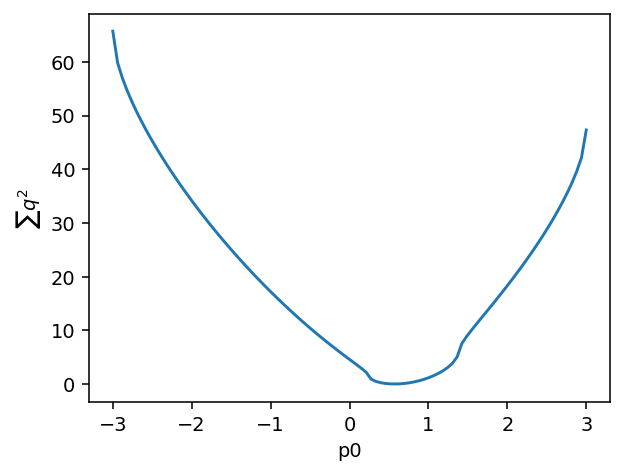

In [13]:
plt.figure()
p0s = np.linspace(min(getWindBuoyantP(rho, flowParams)), max(getWindBuoyantP(rho, flowParams)), 100)
qs = [qObjective(np.array([p0]), rho, flowParams) for p0 in p0s]
plt.plot(p0s, qs)
plt.xlabel("p0")
plt.ylabel("$\sum q^2$")

In [14]:
flowParams = {
    "C_d": [1, 1, 1, 1, 10],
    "A": [1, 1, 1, 1, 3],
    "p_w": [1, 3, 1, -3, 0],
    "z": [3, 3, 6, 3, 0],
    "delT": [-3, 0, 3, 0, 0],
    "q": [2, 2, -1, -3, -4],
    "rooms": [[1, 0], [1, 0], [0, 1], [0, 1], [1, -1]]
}

flowParams = utils.dict_apply(np.array)(flowParams)
p_0s = np.array([1, -1])

display(flowField(p_0s, rho, flowParams))
display(qObjective(p_0s, rho, flowParams))
display(getC(p_0s, rho, flowParams))

array([  0.78230429,   1.80701581,   1.42874285,  -1.80701581,
       -54.21047417])

5562.649436230062

array([ 2.55654996,  1.10679718, -0.69991602,  1.66019577,  0.73786479])

In [15]:
optResults = findOptimalP0(rho, flowParams)
p_0s = optResults.x

display(optResults)
display(flowField(p_0s, rho, flowParams))
display(qObjective(p_0s, rho, flowParams))
display(getC(p_0s, rho, flowParams))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.539052062493129e-07
        x: [ 5.740e-01  5.673e-01]
      nit: 26
      jac: [-1.176e-02  1.180e-02]
     nfev: 156
     njev: 52
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

array([ 1.14345461,  1.99017451, -0.71944691, -2.41334127, -3.13319598])

3.539052062493129e-07

array([ 1.7490856 ,  1.004937  ,  1.38995662,  1.24308983, 12.76651709])

In [52]:
from scipy.optimize import minimize

def getC_ds_AofA(aCorner, aCross, aDual, aSingle, aSinA, aCosA, AofA = 180, roomType="corner"):
    AofA *= np.pi / 180
    C_d = aSinA * np.sin(AofA) + aCosA * np.cos(AofA)
    if roomType == "corner":
        return C_d + aCorner
    if roomType == "cross":
        return C_d + aCross
    if roomType == "dual":
        return C_d + aDual
    if roomType == "single":
        return C_d + aSingle
    
def getC_ds_AofA2(aCorner, aCross, aSingle, aCornerSinA, aCrossSinA, AofA = 180, roomType="corner"):
    AofA *= np.pi / 180
    if roomType == "corner":
        return aCornerSinA * np.sin(AofA) + aCorner
    if roomType == "cross":
        return aCrossSinA * np.sin(AofA) + aCross
    if roomType == "dual":
        return aCornerSinA * np.sin(AofA) + aCorner
    if roomType == "single":
        return aSingle

def getC_ds_AofA3(aCorner, aCross, aDual, aSingle, aSinA, aCosA, sSin2a, aCos2A, AofA = 180, roomType="corner"):
    AofA *= np.pi / 180
    C_d = aSinA * np.sin(AofA) + aCosA * np.cos(AofA) + sSin2a * np.sin(2 * AofA) + aCos2A * np.cos(2 * AofA)
    if roomType == "corner":
        return C_d + aCorner
    if roomType == "cross":
        return C_d + aCross
    if roomType == "dual":
        return C_d + aDual
    if roomType == "single":
        return C_d + aSingle

def getC_ds_EP(aCorner, aCross, aDual, aSingle, aShear, aNormal, shear=0, normal=0, roomType="corner"):
    C_d = aShear * shear + aNormal * normal
    if roomType == "corner":
        return C_d + aCorner
    if roomType == "cross":
        return C_d + aCross
    if roomType == "dual":
        return C_d + aDual
    if roomType == "single":
        return C_d + aSingle

def getC_ds_All(aCorner, aCross, aDual, aSingle, aSinA, aCosA,  aShear, aNormal, aWS, AofA = 180, shear=0, normal=0, WS=0, roomType="corner"):
    AofA *= np.pi / 180
    C_d = aSinA * np.sin(AofA) + aCosA * np.cos(AofA) + aShear * shear + aNormal * normal + aWS * WS
    if roomType == "corner":
        return C_d + aCorner
    if roomType == "cross":
        return C_d + aCross
    if roomType == "dual":
        return C_d + aDual
    if roomType == "single":
        return C_d + aSingle

def getC_ds_opening(aX, aZ, aXSinA, aZSinA, aXCosA, aZCosA, AofA=0, openingType="xwindow"):
    AofA *= np.pi / 180
    if openingType == "xwindow":
        return aX + aXSinA * np.sin(AofA) + aXCosA * np.cos(AofA)
    if openingType == "zwindow":
        return aZ + aZSinA * np.sin(AofA) + aZCosA * np.cos(AofA)

def getC_ds(params, typeC_d="AofA", AofA=0, shear=0, normal=0, openingType="xwindow", roomType="corner"):
    if typeC_d == "AofA":
        return getC_ds_AofA(*params, AofA=AofA, roomType=roomType)
    if typeC_d == "AofA2":
        return getC_ds_AofA2(*params, AofA=AofA, roomType=roomType)
    if typeC_d == "AofA3":
        return getC_ds_AofA3(*params, AofA=AofA, roomType=roomType)
    if typeC_d == "EP":
        return getC_ds_EP(*params, shear=shear, normal=normal, roomType=roomType)
    if typeC_d == "All":
        return getC_ds_All(*params, AofA=AofA, shear=shear, normal=normal, WS=1, roomType=roomType)
    if typeC_d == "opening":
        return getC_ds_opening(*params, openingType=openingType)



def update_flow_and_ventilation(flowStatsMI, roomVentilationMI, paramsC_d, useDoors=True, pTypes = {"pNoInt": "pNoInt"}, typeC_d="AofA"):
    flowStatsMI["cosAofA"] = np.round(np.cos(flowStatsMI["AofA"] * np.pi / 180), 2)
    flowStatsMI["sinAofA"] = np.round(np.sin(flowStatsMI["AofA"] * np.pi / 180), 2)

    for pType in pTypes:
        roomVentilationMI[f"{pType}-success"] = False
    for (run, room), row in roomVentilationMI.iterrows():
        flowParams = {
            "C_d": [],
            "A": [],
            "z": [],
            "delT": [],
            "q": [],
            "rooms": [],
        }
        windowKeyCols = roomVentilationMI.columns[
            roomVentilationMI.columns.str.contains("windowKeys")
        ].tolist()
        windowKeys = row[windowKeyCols].dropna()

        for pType in pTypes:
            flowParams[pType] = []
        for windowKey in windowKeys:
            for pType, pCol in pTypes.items():
                flowParams[pType].append(flowStatsMI.loc[(run, windowKey), pCol])
            C_d = getC_ds(
                paramsC_d,
                typeC_d = typeC_d,
                AofA=flowStatsMI.loc[(run, windowKey),"AofA"], 
                shear=flowStatsMI.loc[(run, windowKey),"EP_shear"], 
                normal=flowStatsMI.loc[(run, windowKey),"EP_normal"],
                openingType = flowStatsMI.loc[(run, windowKey),"openingType"],
                roomType = row["roomType"],
                )
            flowParams["C_d"].append(C_d)
            flowParams["A"].append(A)
            flowParams["z"].append(flowStatsMI.loc[(run, windowKey), "y"])  # y is vertical in simulation
            flowParams["delT"].append(row["mean-T-room"])
            flowParams["q"].append(flowStatsMI.loc[(run, windowKey), "mean-mass_flux"])
            if "dual" in room and useDoors:
                roomCord = windowKey.split("_")[1]
                if roomCord == "0-1":
                    roomRow = [1, 0]
                elif roomCord == "1-1":
                    roomRow = [0, 1]
                else:
                    raise Exception(f"Unrecognized room {roomCord} in dual room")
            else:
                roomRow = [1]
            flowParams["rooms"].append(roomRow)

        if "dual" in room and useDoors:
            H = 3
            for pType in pTypes:
                flowParams[pType].append(0)
            flowParams["C_d"].append(1)
            flowParams["A"].append(A * 3)
            flowParams["z"].append(H / 2)
            flowParams["delT"].append(row["mean-T-room"])
            qRooms = np.matmul(np.array(flowParams["rooms"]).T, np.array(flowParams["q"]))
            flowParams["q"].append(np.diff(qRooms)[0])
            flowParams["rooms"].append([1, -1])

        flowParams = utils.dict_apply(np.array)(flowParams)

        sinAofAs = []
        cosAofAs = []
        for i, windowKey in enumerate(windowKeys):
            sinAofAs.append(flowStatsMI.loc[(run, windowKey), "sinAofA"])
            cosAofAs.append(flowStatsMI.loc[(run, windowKey), "cosAofA"])

        roomVentilationMI.loc[(run, room), "sinAofA"] = np.mean(sinAofAs)
        roomVentilationMI.loc[(run, room), "cosAofA"] = np.mean(cosAofAs)

        for pType in pTypes:
            NRooms = flowParams["rooms"].shape[1]
            flowParams["p_w"] = flowParams[pType]
            p0_meas = [row["mean-p-room"] for i in range(NRooms)]
            C_ds = getC(np.array(p0_meas), rho, flowParams)

            for i, windowKey in enumerate(windowKeys):
                flowStatsMI.loc[(run, windowKey), f"{pType}-C_d"] = C_ds[i]

            optResults = findOptimalP0(rho, flowParams)

            p0 = optResults.x
            roomVentilationMI.loc[(run, room), f"{pType}-p0"] = np.mean(p0)
            roomVentilationMI.loc[(run, room), f"{pType}-success"] = optResults.success
            qs = flowField(np.array(p0), rho, flowParams)

            for i, windowKey in enumerate(windowKeys):
                flowStatsMI.loc[(run, windowKey), f"{pType}-q_model"] = qs[i]
                flowStatsMI.loc[(run, windowKey), f"{pType}-netq_model"] = abs(qs[i])

            if "dual" in room and useDoors:
                qs = qs[0:-1]
            roomVentilationMI.loc[(run, room), f"{pType}-q_model"] = np.sum(abs(np.array(qs))) / 2

    return flowStatsMI, roomVentilationMI


In [18]:
[1.16, 1.31, 1.15, 1, 0, 0]

flowStatsMI, roomVentilationMI = update_flow_and_ventilation(flowStatsMI, roomVentilationMI, [1, 1, 1, 1, 0, 0], useDoors=True,
    pTypes = {
        "pW": "mean-sn_prod(p)",
        "pEP": "EP_p_avg",
        "pNoInt": "pNoInt"
    }
)

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_61601/3067359897.py:25: RuntimeWarning:

divide by zero encountered in divide



In [55]:
flowStatsMINoSL = flowStatsMI[flowStatsMI["AofA"] % 1 == 0].copy()
roomVentilationMINoSL = roomVentilationMI[roomVentilationMI["sinAofA"].notna()].copy()

In [20]:
dfFit = flowStatsMI.dropna(subset=["pNoInt-q_model"])
# Reshape x into a 2D column vector
x = dfFit["pNoInt-q_model"].values.reshape(-1, 1)  # Ensure it's 2D
y = dfFit["mean-mass_flux"].values  # Keep y as 1D

# Solve for the slope (forcing intercept = 0)
CfitWindow, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
CfitWindow = CfitWindow[0]

# Print the fitted coefficient
print("Fitted Coefficient:", CfitWindow)

# Fit C for each room type separately
room_types = dfFit['roomType'].unique()
CfitRoomTypes = {}

for room_type in room_types:
    dfRoomType = dfFit[dfFit['roomType'] == room_type]
    x = dfRoomType["pNoInt-q_model"].values.reshape(-1, 1)  # Ensure it's 2D
    y = dfRoomType["mean-mass_flux"].values  # Keep y as 1D

    # Solve for the slope (forcing intercept = 0)
    Cfit, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
    CfitRoomTypes[room_type] = Cfit[0]

# Print the fitted coefficients for each room type
for room_type, Cfit in CfitRoomTypes.items():
    print(f"Fitted Coefficient for {room_type}: {Cfit}")



Fitted Coefficient: 1.2086008551003806
Fitted Coefficient for corner: 1.1608139851311725
Fitted Coefficient for cross: 1.3172570356631728
Fitted Coefficient for dual: 1.1211105482103625
Fitted Coefficient for single: 0.0


Text(0.5, 1.0, 'Scatter Plot with Fitted Lines')

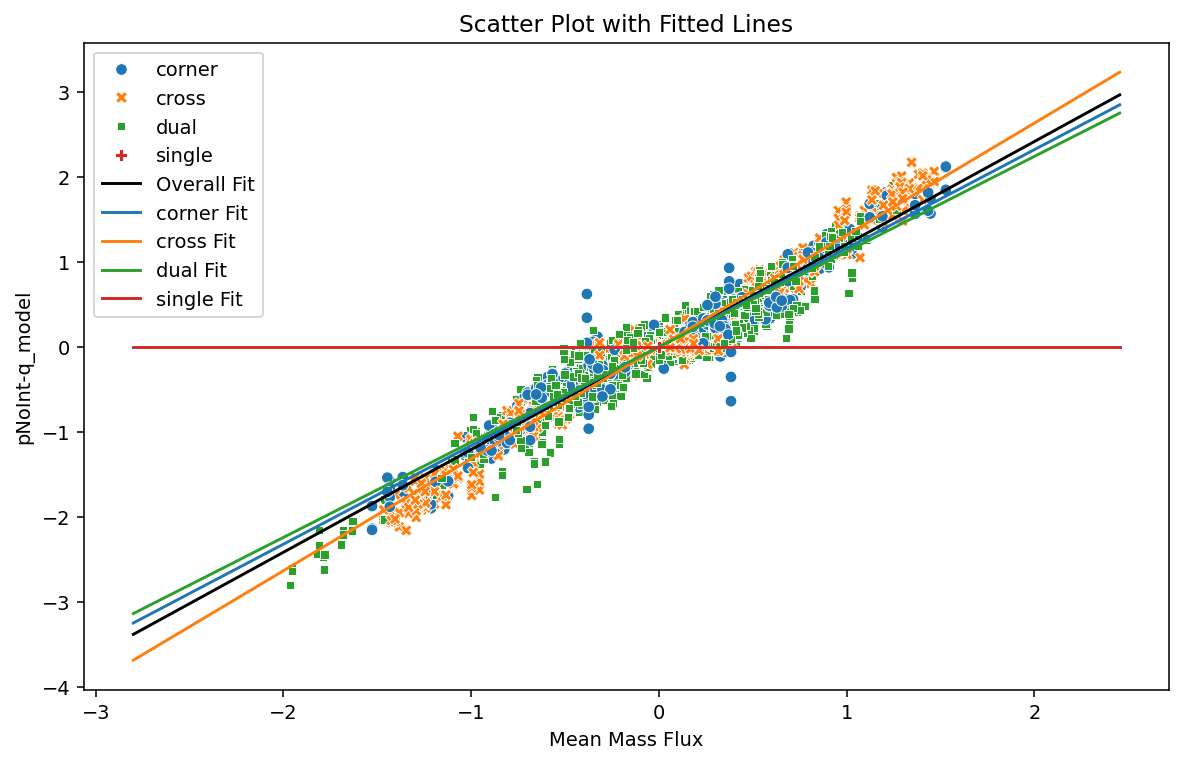

In [21]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=flowStatsMI, x='pNoInt-q_model', y="mean-mass_flux", hue="roomType", style="roomType")

# Overlay the lines from the fitted C values
x_vals = np.linspace(flowStatsMI["mean-mass_flux"].min(), flowStatsMI["mean-mass_flux"].max(), 100)

# Overall fitted line
y_vals_overall = x_vals * CfitWindow
plt.plot(x_vals, y_vals_overall, label='Overall Fit', color='black')

# Fitted lines for each room type
for room_type, Cfit in CfitRoomTypes.items():
    y_vals_room = Cfit * x_vals
    plt.plot(x_vals, y_vals_room, label=f'{room_type} Fit')

plt.legend()
plt.xlabel('Mean Mass Flux')
plt.ylabel('pNoInt-q_model')
plt.title('Scatter Plot with Fitted Lines')

Text(0.5, 1.0, 'Scatter Plot with Fitted Lines')

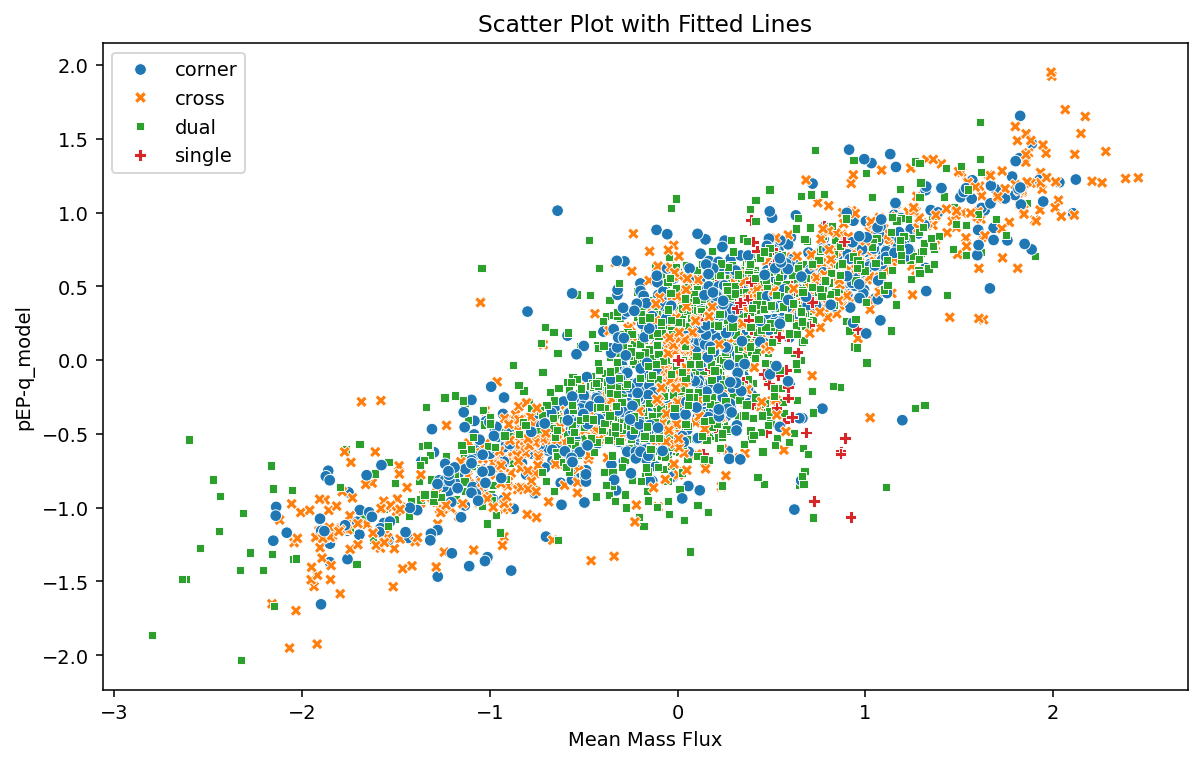

In [22]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=flowStatsMI, x="mean-mass_flux", y='pEP-q_model', hue="roomType", style="roomType")

# Overlay the lines from the fitted C values
x_vals = np.linspace(flowStatsMI["mean-mass_flux"].min(), flowStatsMI["mean-mass_flux"].max(), 100)


plt.legend()
plt.xlabel('Mean Mass Flux')
plt.ylabel('pEP-q_model')
plt.title('Scatter Plot with Fitted Lines')

In [23]:
"""
Angles:
array([ 1.17340176,  1.32334274,  1.15833887,  0.00804852, -0.03391678,
        0.01388756])
0.14092224654844634

Shear/Normal:
array([ 1.16847614e+00,  1.31839869e+00,  1.17020841e+00,  1.62123154e-04,
        1.76884283e-04, -4.20435224e-04])
0.14068568319124428

Openning:
array([ 1.17383905e+00,  1.25949764e+00,  1.04268126e-05,  3.76369301e-05,
       -4.24760102e-05,  1.37200509e-04])
0.14497885547335324

AofA2:
array([ 1.17132613e+00,  1.31910337e+00,  2.03823868e-04, -4.39502373e-04,
        2.03392091e-04])
0.14071399814356256
"""

'\nAngles:\narray([ 1.17340176,  1.32334274,  1.15833887,  0.00804852, -0.03391678,\n        0.01388756])\n0.14092224654844634\n\nShear/Normal:\narray([ 1.16847614e+00,  1.31839869e+00,  1.17020841e+00,  1.62123154e-04,\n        1.76884283e-04, -4.20435224e-04])\n0.14068568319124428\n\nOpenning:\narray([ 1.17383905e+00,  1.25949764e+00,  1.04268126e-05,  3.76369301e-05,\n       -4.24760102e-05,  1.37200509e-04])\n0.14497885547335324\n\nAofA2:\narray([ 1.17132613e+00,  1.31910337e+00,  2.03823868e-04, -4.39502373e-04,\n        2.03392091e-04])\n0.14071399814356256\n'

In [22]:
# def qRMSE(df):
#     return np.sqrt(np.mean((df["pNoInt-q_model"] - df["mean-mass_flux"])**2))

# def objective(params, flowStatsMI = flowStatsMINoSL, roomVentilationMI = roomVentilationMINoSL):
#     display(params)
#     flowStatsMI, roomVentilationMI = update_flow_and_ventilation(flowStatsMI, roomVentilationMI, params, typeC_d="AofA3")
#     RMSE = qRMSE(roomVentilationMI)
#     display(RMSE)
#     return RMSE
# initial_guess = [ 1.17340176,  1.32334274,  1.15833887,  0.00804852, -0.03391678, 0.01388756, 0, 0]
# result = minimize(objective, initial_guess, method='Nelder-Mead')

In [ ]:
flowStatsMI

In [25]:
plotdf = roomVentilationMI.copy()
plotdf["x"] = plotdf["mean-p-room"]**0.5
plotdf["y"] = plotdf["pNoInt-p0"]**0.5
px.scatter(data_frame=plotdf, x="x", y='y', symbol = "houseType", color = "roomType")

In [23]:
px.scatter(data_frame=roomVentilationMI, x="pEP-p0", y='pNoInt-p0', symbol = "houseType", color = "roomType")

In [20]:
px.box(data_frame=flowStatsMI.sort_values(["AofA", "roomType"]), x="pNoInt-C_d", color = "AofA", facet_col = "roomType")

In [21]:
px.box(data_frame=flowStatsMI.sort_values(["AofA", "roomType"]), x="pNoInt-C_d", color = "AofA", facet_col = "roomType")

In [22]:
px.box(data_frame=flowStatsMI.sort_values(["AofA", "roomType"]), x="pNoInt-C_d", color = "AofA", facet_col = "openingType")

In [23]:
px.box(data_frame=flowStatsMI.sort_values(["AofA"]), x="pNoInt-C_d", color = "AofA")

In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

# Filter and sort the data
flowStatsMINoSL = flowStatsMI[flowStatsMI["AofA"] % 1 == 0]
flowStatsMINoSL.sort_values(by=["WS", "AofA"], inplace=True)

# Define substrings to keep and drop
subStrKeep = ["pNoInt-C_d", "sinAofA", "cosAofA", "roomType", "WS", "EP_normal", "EP_shear", "mean-mass_flux", "openingType"]
meanKmeansDf = flowStatsMINoSL[subStrKeep]

# Convert roomType to numeric
meanKmeansDf["roomType"] = meanKmeansDf["roomType"].astype('category').cat.codes
meanKmeansDf["openingType"] = meanKmeansDf["openingType"].astype('category').cat.codes

# Perform z-score normalization
mean = np.mean(meanKmeansDf, axis=0)
std = np.std(meanKmeansDf, axis=0)
meanKmeansDf = (meanKmeansDf - mean) / std

# Apply K-Means Algorithm
k = 4
kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
kmeans.fit(meanKmeansDf)

# Assign cluster labels
flowStatsMINoSL["labels"] = kmeans.labels_.astype(str)

# Perform SVD decomposition
svd = TruncatedSVD(n_components=3)
meanKmeansDfLowDim = svd.fit_transform(meanKmeansDf)

# Visualize the clusters
fig = px.scatter_3d(data_frame=flowStatsMINoSL, x=meanKmeansDfLowDim[:, 0], y=meanKmeansDfLowDim[:, 1], z=meanKmeansDf["pNoInt-C_d"], color="labels")
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=1200, height=800, legend=dict(x=0, y=1.1))
fig.show()

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_39755/1841201372.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_39755/1841201372.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_39755/1841201372.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

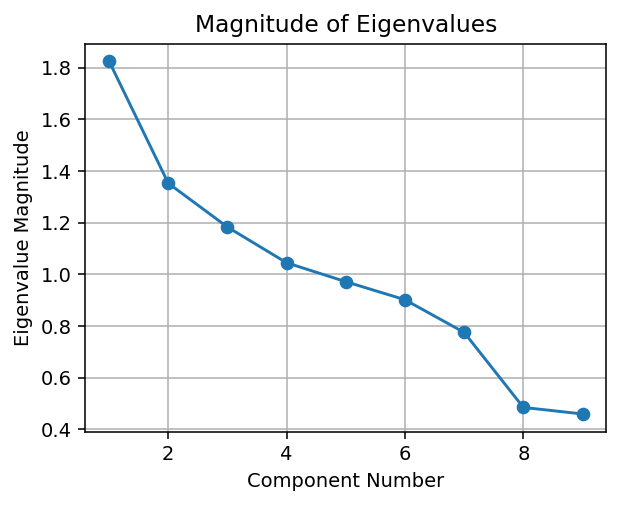

In [25]:
# Perform SVD decomposition
svd = TruncatedSVD(n_components=meanKmeansDf.shape[1])
meanKmeansDfLowDim = svd.fit_transform(meanKmeansDf)

# Plot the magnitude of the eigenvalues
plt.figure()
plt.plot(range(1, len(svd.explained_variance_) + 1), svd.explained_variance_, marker='o')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue Magnitude')
plt.title('Magnitude of Eigenvalues')
plt.grid(True)
plt.show()

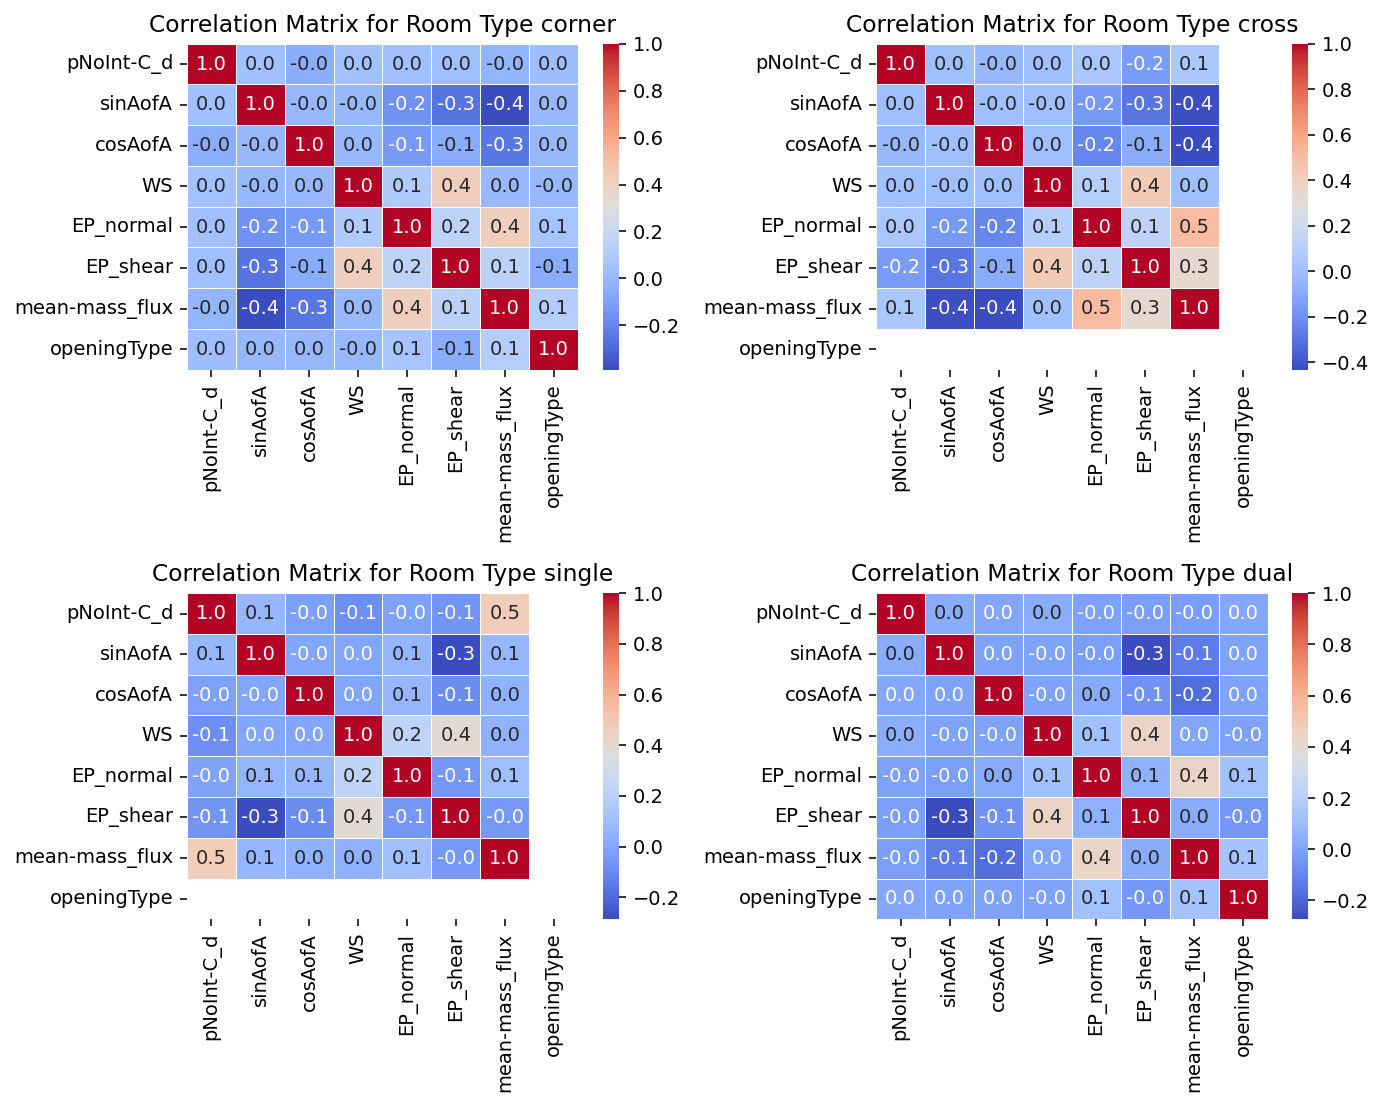

In [26]:
corrDf = meanKmeansDf.copy()
corrDf['roomType'] = flowStatsMINoSL['roomType']

# Split the data by roomType
room_types = corrDf['roomType'].unique()

# Plot correlation matrices for each roomType
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, room_type in zip(axes, room_types):
    room_data = corrDf[corrDf['roomType'] == room_type]
    room_data = room_data.drop(columns='roomType')
    corr_matrix = room_data.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5, ax=ax)
    ax.set_title(f'Correlation Matrix for Room Type {room_type}')

plt.tight_layout()

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the features (independent variables) and target (dependent variable)
features = ['AofA', 'roomType', 'WS', 'EP_normal', 'EP_shear', 'mean-mass_flux']
X = meanKmeansDf[features]
y = meanKmeansDf['pNoInt-C_d']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Display the coefficients
coefficients = pd.DataFrame(model.coef_, features, columns=['Coefficient'])
print(coefficients)

KeyError: "['AofA'] not in index"

In [28]:
px.scatter(data_frame=flowStatsMI, x="mean-mass_flux", y='pNoInt-q_model', color = "AofA_resid")

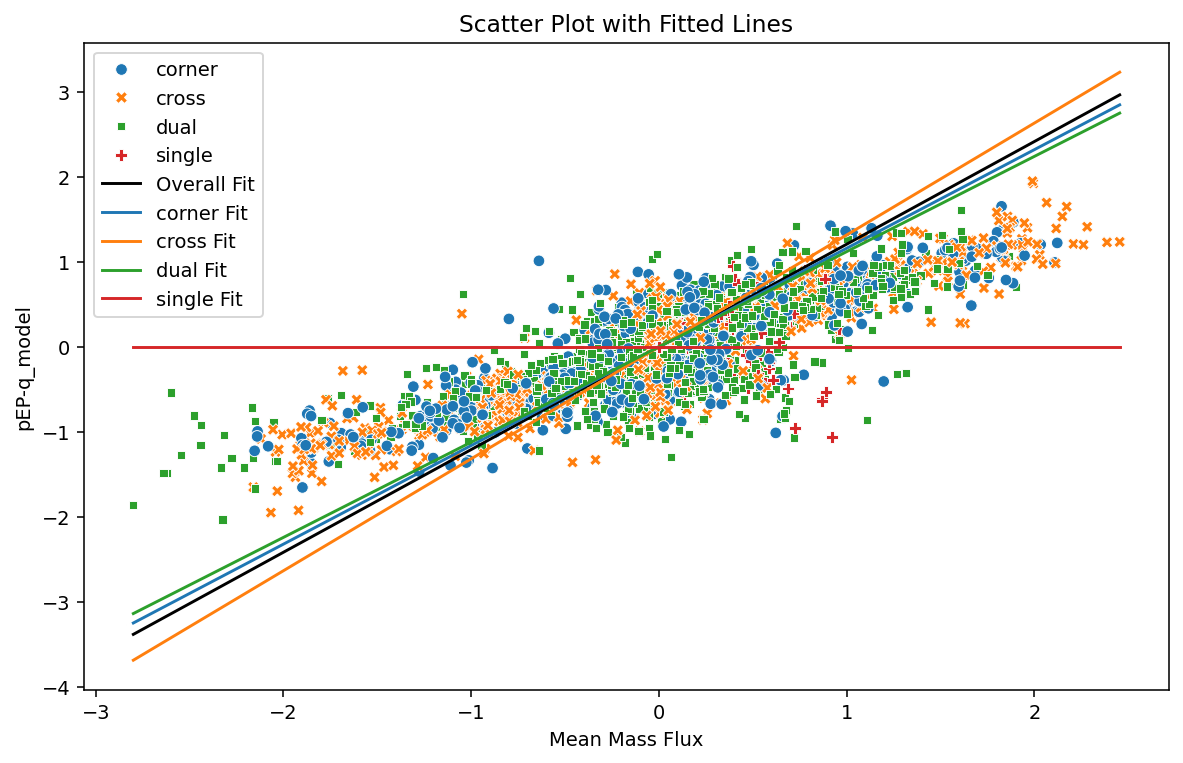

In [29]:
import seaborn as sns

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=flowStatsMI, x="mean-mass_flux", y='pEP-q_model', hue="roomType", style="roomType")

# Overlay the lines from the fitted C values
x_vals = np.linspace(flowStatsMI["mean-mass_flux"].min(), flowStatsMI["mean-mass_flux"].max(), 100)

# Overall fitted line
y_vals_overall = CfitWindow * x_vals
plt.plot(x_vals, y_vals_overall, label='Overall Fit', color='black')

# Fitted lines for each room type
for room_type, Cfit in CfitRoomTypes.items():
    y_vals_room = Cfit * x_vals
    plt.plot(x_vals, y_vals_room, label=f'{room_type} Fit')

plt.legend()
plt.xlabel('Mean Mass Flux')
plt.ylabel('pEP-q_model')
plt.title('Scatter Plot with Fitted Lines')
plt.show()

In [30]:
px.scatter(data_frame=roomVentilationMI, x="mean-mass_flux", y='pNoInt-q_model', symbol = "houseType", color = "roomType")

In [31]:
px.scatter(data_frame=roomVentilationMI, x="mean-mass_flux", y='pEP-q_model', symbol = "houseType", color = "roomType")

In [32]:
roomVentilationMI["sinAofA"]

2530  corner_h_0--1_B   -0.710000
      cross_h_0--1_B     0.000000
      dual_h_0--1_B      0.236667
      single_h_0--1_B   -0.710000
      corner_h_0--2_B   -0.710000
                           ...   
3242  single_h_0-2_Bz    0.000000
      corner_sl_Bz            NaN
      cross_sl_Bz             NaN
      dual_sl_Bz              NaN
      single_sl_Bz            NaN
Name: sinAofA, Length: 2304, dtype: float64

In [33]:
px.scatter(data_frame=roomVentilationMI, x="mean-mass_flux", y='pEP-q_model', symbol = "houseType", color = "sinAofA")

In [34]:
dfFit = roomVentilationMI.dropna(subset=["pNoInt-q_model"])
# Reshape x into a 2D column vector
x = dfFit["mean-mass_flux"].values.reshape(-1, 1)  # Ensure it's 2D
y = dfFit["pNoInt-q_model"].values  # Keep y as 1D

# Solve for the slope (forcing intercept = 0)
CfitRooms, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
CfitRooms = CfitRooms[0]

# Print the fitted coefficient
print("Fitted Coefficient:", CfitRooms)

Fitted Coefficient: 0.7819804443095097


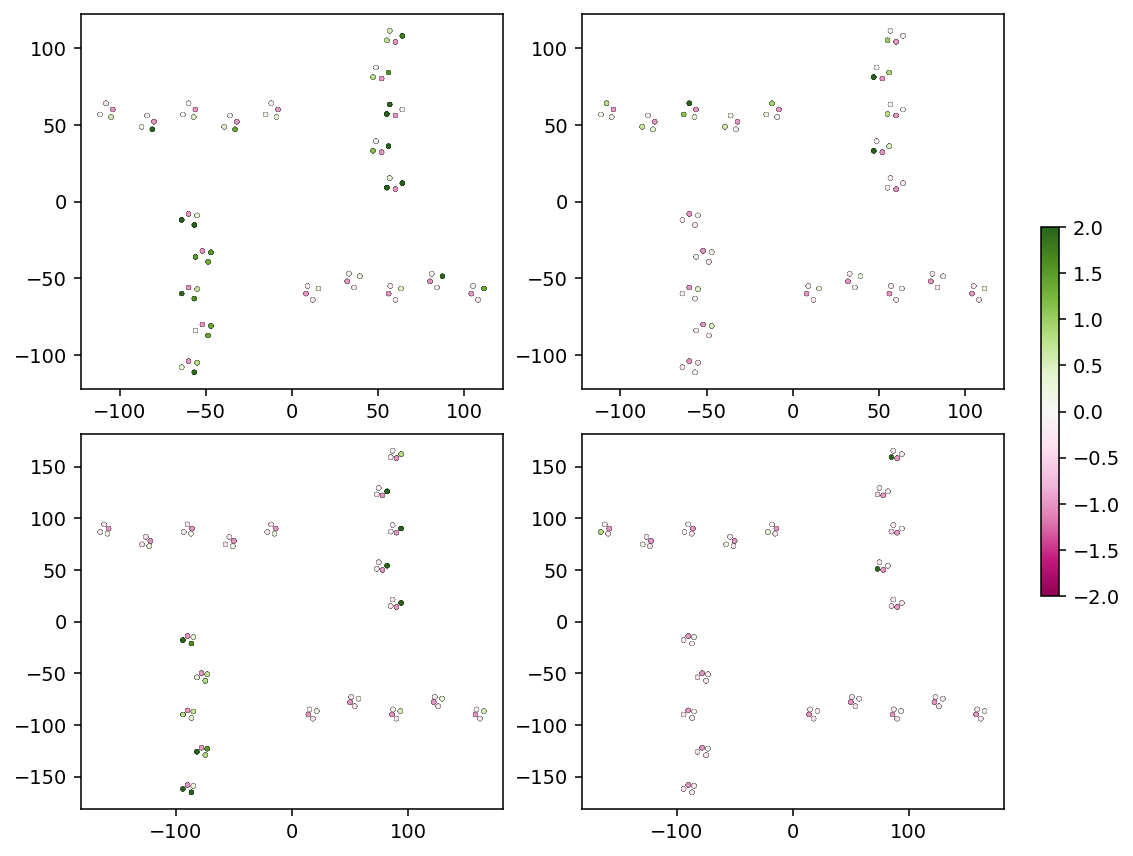

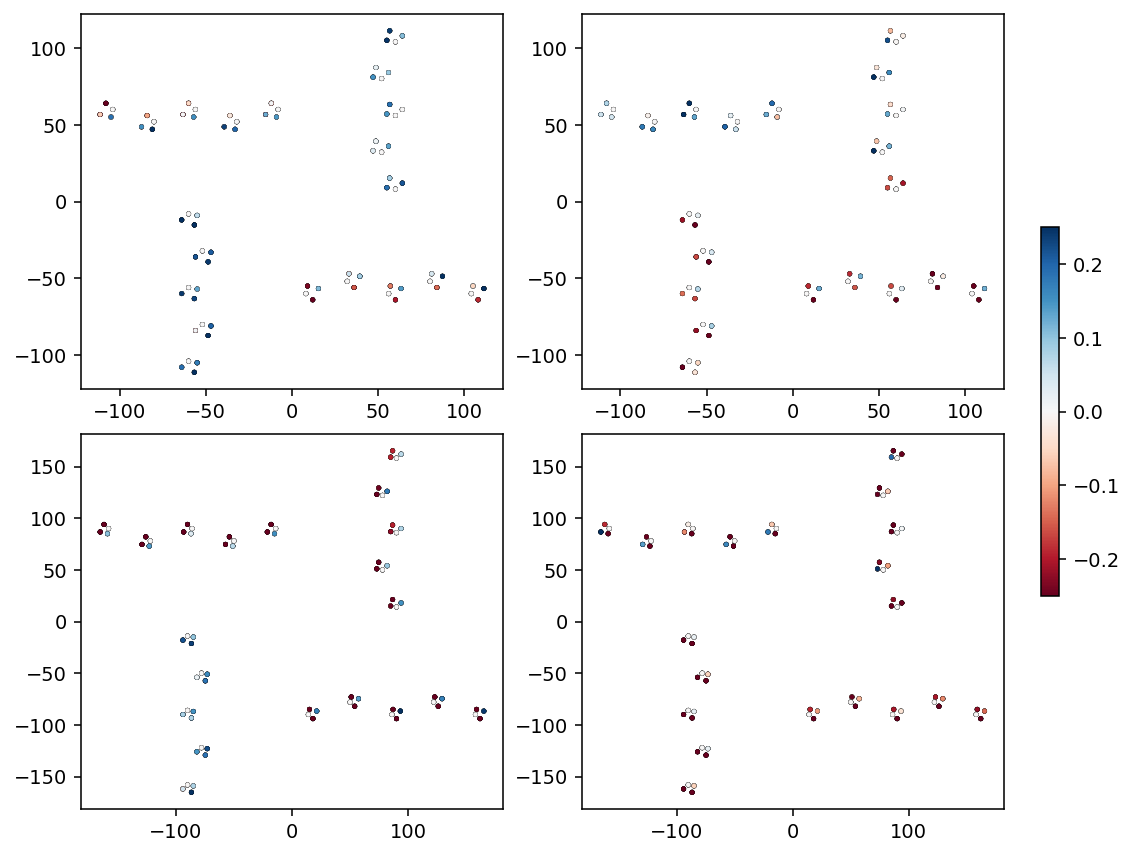

In [35]:
CfitRooms = 1
roomVentilationMI["q_model-diff"] = roomVentilationMI["pNoInt-q_model"]/CfitRooms - roomVentilationMI["mean-mass_flux"]
roomVentilationMI["q_model-error"] = roomVentilationMI["q_model-diff"] / roomVentilationMI["mean-mass_flux"]

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 6))
conditions = [(2, 0), (2, 45), (3, 0), (3, 45)]
for ax, (C, A) in zip(axs.flat, conditions):
    plotdf = roomVentilationMI[(roomVentilationMI["C"] == C) & (roomVentilationMI["A"] == A)]
    im = ax.scatter(plotdf['x'], plotdf['z'], s=8*im_scaling, c=plotdf["q_model-error"], cmap='PiYG', edgecolors="black", linewidths=.1, vmin=-2, vmax=2)
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 6))
for ax, (C, A) in zip(axs.flat, conditions):
    plotdf = roomVentilationMI[(roomVentilationMI["C"] == C) & (roomVentilationMI["A"] == A)]
    im = ax.scatter(plotdf['x'], plotdf['z'], s=8*im_scaling, c=plotdf["q_model-diff"], cmap='RdBu', edgecolors="black", linewidths=.1, vmin=-.25, vmax=.25)
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

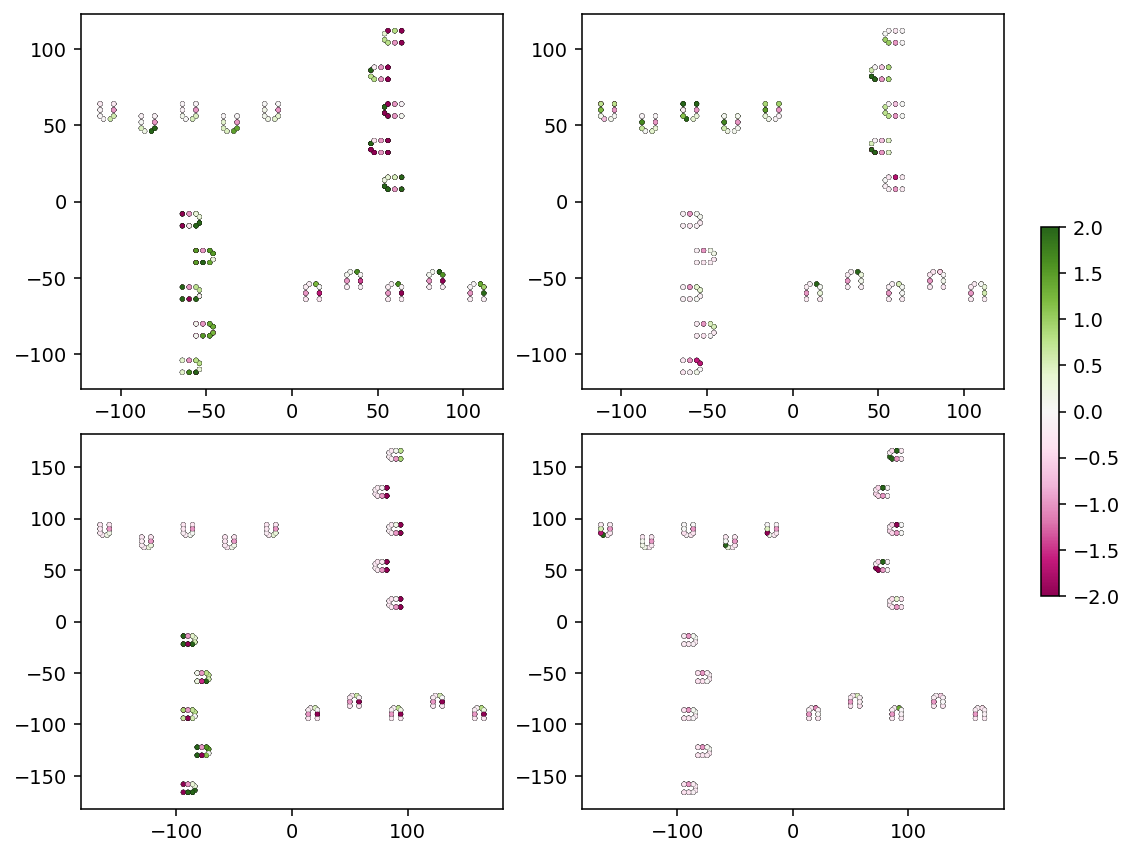

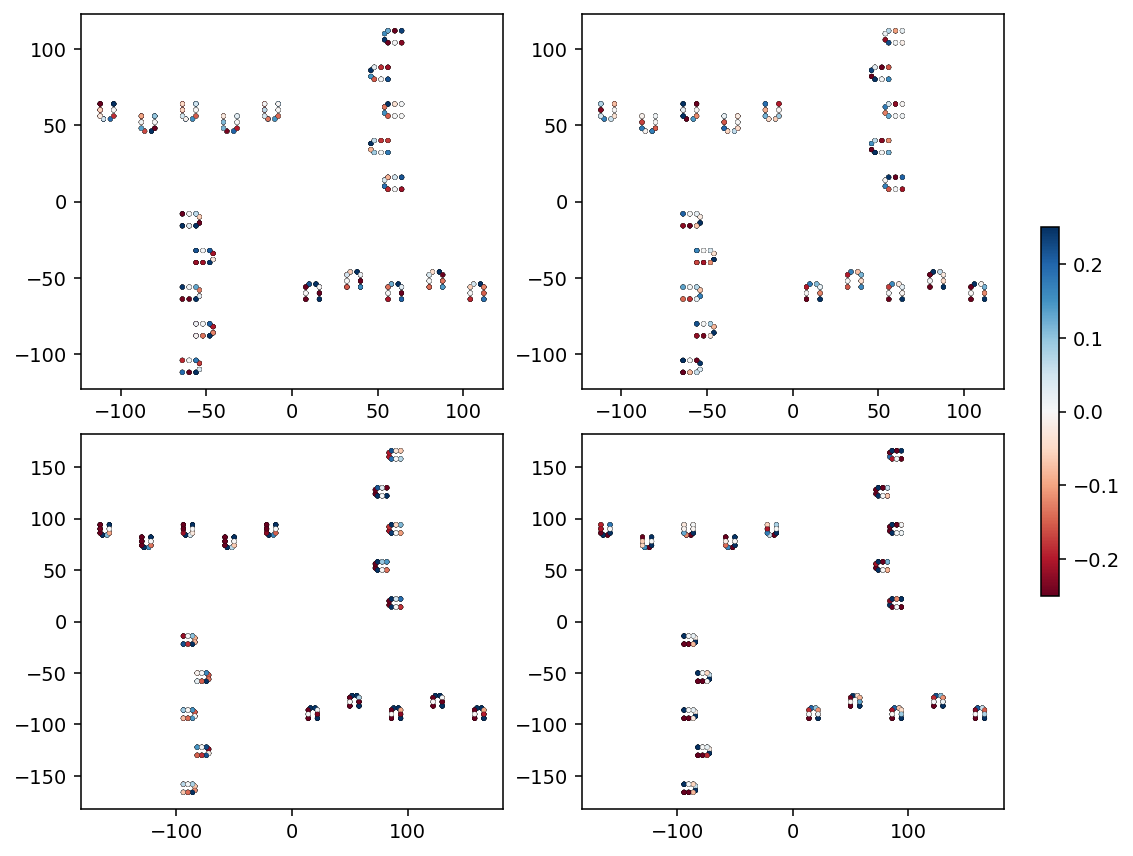

In [36]:
flowStatsMI["q_model-diff"] = flowStatsMI["pNoInt-q_model"]/CfitRooms - flowStatsMI["mean-mass_flux"]
flowStatsMI["q_model-error"] = flowStatsMI["q_model-diff"] / flowStatsMI["mean-mass_flux"]

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 6))
conditions = [(2, 0), (2, 45), (3, 0), (3, 45)]
for ax, (C, A) in zip(axs.flat, conditions):
    plotdf = flowStatsMI[(flowStatsMI["C"] == C) & (flowStatsMI["A"] == A)]
    im = ax.scatter(plotdf['x'], plotdf['z'], s=8*im_scaling, c=plotdf["q_model-error"], cmap='PiYG', edgecolors="black", linewidths=.1, vmin=-2, vmax=2)
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 6))
conditions = [(2, 0), (2, 45), (3, 0), (3, 45)]
for ax, (C, A) in zip(axs.flat, conditions):
    plotdf = flowStatsMI[(flowStatsMI["C"] == C) & (flowStatsMI["A"] == A)]
    im = ax.scatter(plotdf['x'], plotdf['z'], s=8*im_scaling, c=plotdf["q_model-diff"], cmap='RdBu', edgecolors="black", linewidths=.1, vmin=-.25, vmax=.25)
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)